In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn import metrics
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

#Data

In [ ]:
def concatenate_fasta_files(file1_path, file2_path, output_path):
    with open(file1_path, 'r') as file1:
        content1 = file1.read()

    with open(file2_path, 'r') as file2:
        content2 = file2.read()
    concatenated_content = content1 + content2
    with open(output_path, 'w') as output_file:
        output_file.write(concatenated_content)

file1_path = '/content/WuKou2016_filter-norm_to_512.fasta'
file2_path = '/content/zdna2016_filter-norm_to_512 (1).fasta'
output_path = 'Real_ZDNA.fasta'

concatenate_fasta_files(file1_path, file2_path, output_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/WuKou2016_filter-norm_to_512.fasta'

In [ ]:
file1_path = "/content/Real_ZDNA.fasta"
file2_path = "/content/G4_Chip_seq_quadruplex_norm_to_500.fa"
output_path = 'Real_F.fasta'

concatenate_fasta_files(file1_path, file2_path, output_path)

In [ ]:
real_G_quad = "/content/G4_Chip_seq_quadruplex_norm_to_500.fa"
diff_G_quad = "/content/diff_generated_G4.fasta"
wgan_G_quad = "/content/generated_wgan_G4.fasta"
vae_G_quad = "/content/generated_Gquad_vqvae.fasta"

real_ZDNA = "/content/Real_ZDNA.fasta"
diff_ZDNA = "/content/diff_generated_sequences_ZDNA.fasta"
wgan_ZDNA = "/content/generated_wgan_ZDNA (1).fasta"
vae_ZDNA = "/content/generated_sequences_ZDNA_vavae (1).fasta"

real_F = "/content/Real_F.fasta"
diff_F = "/content/diff_generated_sequences_fulldata.fasta"
wgan_F = "/content/wgan_generated_sequences_fulldata.fasta"
vae_F = "/content/generated_sequences_vqvae_fulldata.fasta"

In [ ]:
files = [real_G_quad,
         diff_G_quad,
         wgan_G_quad,
         vae_G_quad,
         real_F,
         diff_F,
         wgan_F,
         vae_F]

In [ ]:
ZDNA_files =[
         real_ZDNA,
         diff_ZDNA,
         wgan_ZDNA,
         vae_ZDNA,
]

In [ ]:
codes = {
 'A': [1., 0., 0., 0., 0.],
 'T': [0., 1., 0., 0., 0.],
 'G': [0., 0., 1., 0., 0.],
 'C': [0., 0., 0., 1., 0.],
 'N': [0., 0., 0., 0., 1.],
 }

In [ ]:
for file in files:
    # Normalisation
    one_hot_quads = []
    line_num = 0
    with open(file, 'r') as f:
      for line in f:
        if line[0] != '>':
          one_hot = []
          for s in line.upper():
            if s != '\n':
              one_hot.append(codes[s])
          one_hot_quads.append(one_hot)
          line_num += 1
    one_hot_quads_np = np.array(one_hot_quads)
    print(f'Shape of {file}', one_hot_quads_np.shape)
    np.save(f'{file}.npy', one_hot_quads_np)

Shape of /content/G4_Chip_seq_quadruplex_norm_to_500.fa (8723, 512, 5)
Shape of /content/diff_generated_G4.fasta (8764, 100, 5)
Shape of /content/generated_wgan_G4.fasta (8723, 100, 5)
Shape of /content/generated_Gquad_vqvae.fasta (8723, 100, 5)
Shape of /content/Real_F.fasta (53384, 512, 5)
Shape of /content/diff_generated_sequences_fulldata.fasta (53388, 100, 5)
Shape of /content/wgan_generated_sequences_fulldata.fasta (53384, 100, 5)
Shape of /content/generated_sequences_vqvae_fulldata.fasta (53384, 100, 5)


In [ ]:
for file in ZDNA_files:
    # Normalisation
    one_hot_quads = []
    line_num = 0
    with open(file, 'r') as f:
      for line in f:
        if line[0] != '>':
          one_hot = []
          for s in line.upper():
            if s != '\n':
              one_hot.append(codes[s])
          one_hot_quads.append(one_hot)
          line_num += 1
    one_hot_quads_np = np.array(one_hot_quads)
    print(f'Shape of {file}', one_hot_quads_np.shape)
    np.save(f'{file}.npy', one_hot_quads_np)

Shape of /content/Real_ZDNA.fasta (44661, 512, 5)
Shape of /content/diff_generated_sequences_ZDNA.fasta (44652, 100, 5)
Shape of /content/generated_wgan_ZDNA (1).fasta (44661, 512, 5)
Shape of /content/generated_sequences_ZDNA_vavae (1).fasta (44661, 100, 5)


# Model

In [ ]:
class G4Detector(nn.Module):
    def __init__(self, onehot_len):
        super(G4Detector, self).__init__()
        self.conv1 = nn.Conv1d(onehot_len, 80, 2)
        self.conv2 = nn.Conv1d(onehot_len, 80, 3)
        self.conv3 = nn.Conv1d(onehot_len, 96, 6)
        self.linear_block = nn.Sequential(nn.Linear(256, 32),
                                          nn.ReLU(), nn.Linear(32, 1), nn.Sigmoid())

    def forward(self, x):
        output = x.transpose(1, 2)
        output1 = self.conv1(output)
        output2 = self.conv2(output)
        output3 = self.conv3(output)
        (output1, _) = torch.max(output1, 2)
        (output2, _) = torch.max(output2, 2)
        (output3, _) = torch.max(output3, 2)
        output = torch.cat([output1, output2, output3], dim=1)
        output = self.linear_block(output)
        return output

In [ ]:
detector = G4Detector(onehot_len=5)
detector

G4Detector(
  (conv1): Conv1d(5, 80, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(5, 80, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(5, 96, kernel_size=(6,), stride=(1,))
  (linear_block): Sequential(
    (0): Linear(in_features=256, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

[1,    10] loss: 0.692 acc: 0.521
[1,    20] loss: 0.692 acc: 0.500
[1,    30] loss: 0.690 acc: 0.562
[1,    40] loss: 0.693 acc: 0.487
[1,    50] loss: 0.689 acc: 0.567
[1,    60] loss: 0.688 acc: 0.713
[1,    70] loss: 0.687 acc: 0.537
[1,    80] loss: 0.690 acc: 0.484
[1,    90] loss: 0.686 acc: 0.612
[1,   100] loss: 0.685 acc: 0.745
[1,   110] loss: 0.684 acc: 0.802
[1,   120] loss: 0.684 acc: 0.656
[2,    10] loss: 0.682 acc: 0.564
[2,    20] loss: 0.683 acc: 0.558
[2,    30] loss: 0.680 acc: 0.739
[2,    40] loss: 0.679 acc: 0.675
[2,    50] loss: 0.678 acc: 0.782
[2,    60] loss: 0.677 acc: 0.805
[2,    70] loss: 0.677 acc: 0.702
[2,    80] loss: 0.673 acc: 0.701
[2,    90] loss: 0.674 acc: 0.661
[2,   100] loss: 0.671 acc: 0.758
[2,   110] loss: 0.671 acc: 0.830
[2,   120] loss: 0.667 acc: 0.830
[3,    10] loss: 0.666 acc: 0.766
[3,    20] loss: 0.664 acc: 0.688
[3,    30] loss: 0.663 acc: 0.795
[3,    40] loss: 0.659 acc: 0.743
[3,    50] loss: 0.662 acc: 0.745
[3,    60] los

Text(0.5, 0, 'Recall')

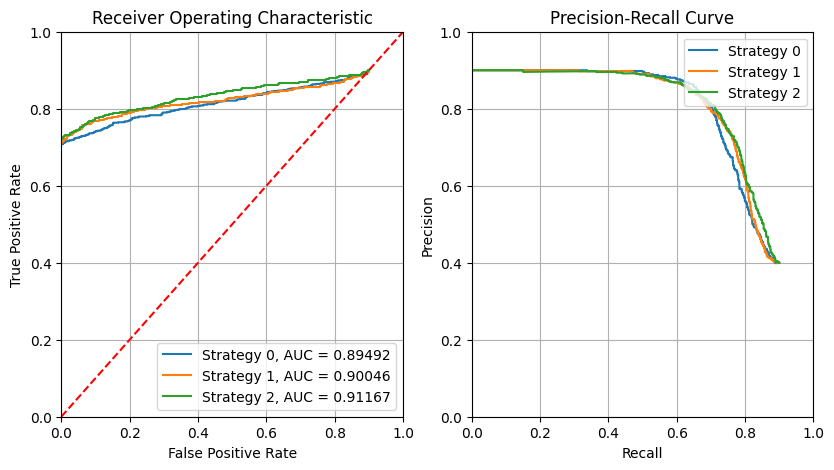

In [ ]:
g4_np_data_path = '/content/G4_Chip_seq_quadruplex_norm_to_500.fa.npy'
batch_size = 128
test_ratio = 0.1
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/diff_generated_G4.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.0001
    beta_1 = 0.9
    beta_2 = 0.99
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

# Plot ROC curves for each strategy
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic')
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    plt.plot(fpr_list[i] - 0.1, tpr_list[i] - 0.1, label=f'Strategy {strategy}, AUC = {roc_auc:.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i] - 0.1, precision_list[i]- 0.1, label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')


In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1 Score: {f1_score:.5f}")

Strategy 0 - ROC AUC: 0.90351, Precision: 0.80495, Recall: 0.70164, F1 Score: 0.85442
Strategy 1 - ROC AUC: 0.99578, Precision: 0.84474, Recall: 0.74760, F1 Score: 0.97439
Strategy 2 - ROC AUC: 0.99395, Precision: 0.84391, Recall: 0.74683, F1 Score: 0.98087


[1,    10] loss: 0.693 acc: 0.501
[1,    20] loss: 0.692 acc: 0.527
[1,    30] loss: 0.691 acc: 0.539
[1,    40] loss: 0.691 acc: 0.502
[1,    50] loss: 0.690 acc: 0.642
[1,    60] loss: 0.688 acc: 0.695
[1,    70] loss: 0.688 acc: 0.614
[1,    80] loss: 0.687 acc: 0.536
[1,    90] loss: 0.687 acc: 0.519
[1,   100] loss: 0.683 acc: 0.626
[1,   110] loss: 0.684 acc: 0.554
[1,   120] loss: 0.683 acc: 0.713
[2,    10] loss: 0.681 acc: 0.811
[2,    20] loss: 0.680 acc: 0.779
[2,    30] loss: 0.678 acc: 0.783
[2,    40] loss: 0.677 acc: 0.837
[2,    50] loss: 0.676 acc: 0.804
[2,    60] loss: 0.674 acc: 0.777
[2,    70] loss: 0.673 acc: 0.756
[2,    80] loss: 0.672 acc: 0.702
[2,    90] loss: 0.670 acc: 0.766
[2,   100] loss: 0.671 acc: 0.706
[2,   110] loss: 0.668 acc: 0.788
[2,   120] loss: 0.667 acc: 0.818
[3,    10] loss: 0.664 acc: 0.806
[3,    20] loss: 0.661 acc: 0.841
[3,    30] loss: 0.661 acc: 0.833
[3,    40] loss: 0.657 acc: 0.798
[3,    50] loss: 0.658 acc: 0.766
[3,    60] los

Text(0.5, 0, 'Recall')

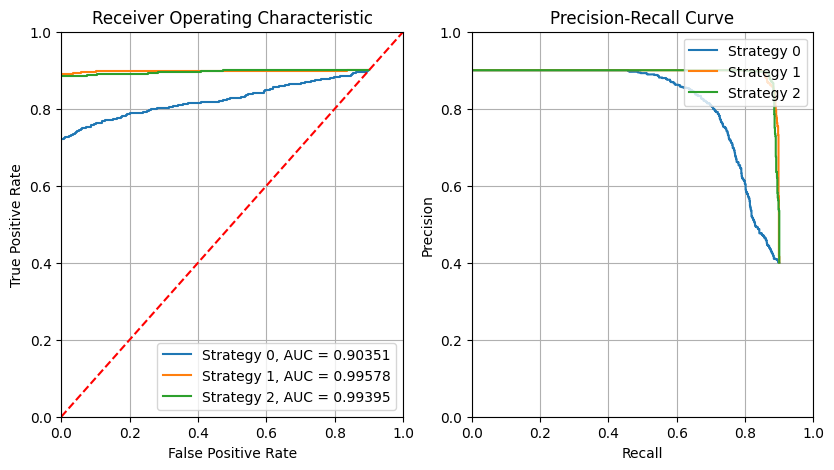

In [ ]:
g4_np_data_path = '/content/G4_Chip_seq_quadruplex_norm_to_500.fa.npy'
batch_size = 128
test_ratio = 0.1
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/generated_wgan_G4.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.0001
    beta_1 = 0.9
    beta_2 = 0.99
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

# Plot ROC curves for each strategy
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic')
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    plt.plot(fpr_list[i] - 0.1, tpr_list[i] - 0.1, label=f'Strategy {strategy}, AUC = {roc_auc:.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i] - 0.1, precision_list[i]- 0.1, label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1 Score: {f1_score:.5f}")

Strategy 0 - ROC AUC: 0.90351, Precision: 0.80495, Recall: 0.70164, F1 Score: 0.85442
Strategy 1 - ROC AUC: 0.99578, Precision: 0.84474, Recall: 0.74760, F1 Score: 0.97439
Strategy 2 - ROC AUC: 0.99395, Precision: 0.84391, Recall: 0.74683, F1 Score: 0.98087


[1,    10] loss: 0.691 acc: 0.521
[1,    20] loss: 0.691 acc: 0.512
[1,    30] loss: 0.691 acc: 0.497
[1,    40] loss: 0.689 acc: 0.620
[1,    50] loss: 0.688 acc: 0.514
[1,    60] loss: 0.686 acc: 0.515
[1,    70] loss: 0.686 acc: 0.678
[1,    80] loss: 0.684 acc: 0.655
[1,    90] loss: 0.684 acc: 0.635
[1,   100] loss: 0.682 acc: 0.766
[2,    10] loss: 0.681 acc: 0.554
[2,    20] loss: 0.680 acc: 0.754
[2,    30] loss: 0.679 acc: 0.708
[2,    40] loss: 0.676 acc: 0.729
[2,    50] loss: 0.674 acc: 0.803
[2,    60] loss: 0.673 acc: 0.664
[2,    70] loss: 0.671 acc: 0.692
[2,    80] loss: 0.668 acc: 0.803
[2,    90] loss: 0.666 acc: 0.835
[2,   100] loss: 0.665 acc: 0.763
[3,    10] loss: 0.664 acc: 0.742
[3,    20] loss: 0.661 acc: 0.786
[3,    30] loss: 0.659 acc: 0.801
[3,    40] loss: 0.657 acc: 0.854
[3,    50] loss: 0.654 acc: 0.845
[3,    60] loss: 0.654 acc: 0.806
[3,    70] loss: 0.652 acc: 0.786
[3,    80] loss: 0.648 acc: 0.820
[3,    90] loss: 0.643 acc: 0.845
[3,   100] los

Text(0.5, 0, 'Recall')

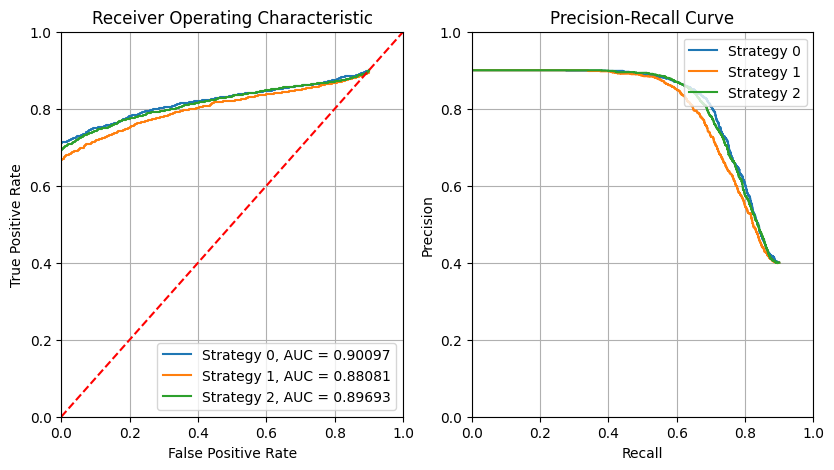

In [ ]:
g4_np_data_path = '/content/G4_Chip_seq_quadruplex_norm_to_500.fa.npy'
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/generated_Gquad_vqvae.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.0001
    beta_1 = 0.9
    beta_2 = 0.99
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

# Plot ROC curves for each strategy
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic')
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    plt.plot(fpr_list[i] - 0.1, tpr_list[i] - 0.1, label=f'Strategy {strategy}, AUC = {roc_auc:.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i] - 0.1, precision_list[i]- 0.1, label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1 Score: {f1_score:.5f}")

Strategy 0 - ROC AUC: 0.98699, Precision: 0.83737, Recall: 0.75375, F1 Score: 0.94381
Strategy 1 - ROC AUC: 0.95036, Precision: 0.79061, Recall: 0.82823, F1 Score: 0.87567
Strategy 2 - ROC AUC: 0.98795, Precision: 0.81424, Recall: 0.84092, F1 Score: 0.94690


#ZDNA

In [ ]:
input_fake = np.load('/content/diff_generated_sequences_fulldata.fasta.npy')

In [ ]:
input_fake.shape

(53388, 100, 5)

[1,    10] loss: 0.700 acc: 0.524
[1,    20] loss: 0.693 acc: 0.500
[1,    30] loss: 0.683 acc: 0.494
[1,    40] loss: 0.639 acc: 0.627
[1,    50] loss: 0.543 acc: 0.777
[1,    60] loss: 0.415 acc: 0.870
[1,    70] loss: 0.362 acc: 0.859
[1,    80] loss: 0.378 acc: 0.851
[1,    90] loss: 0.343 acc: 0.854
[1,   100] loss: 0.327 acc: 0.860
[1,   110] loss: 0.288 acc: 0.899
[1,   120] loss: 0.275 acc: 0.894
[1,   130] loss: 0.268 acc: 0.898
[1,   140] loss: 0.286 acc: 0.887
[1,   150] loss: 0.232 acc: 0.909
[1,   160] loss: 0.193 acc: 0.919
[1,   170] loss: 0.225 acc: 0.905
[1,   180] loss: 0.218 acc: 0.909
[1,   190] loss: 0.211 acc: 0.918
[1,   200] loss: 0.200 acc: 0.917
[1,   210] loss: 0.223 acc: 0.908
[1,   220] loss: 0.178 acc: 0.926
[1,   230] loss: 0.230 acc: 0.901
[1,   240] loss: 0.203 acc: 0.931
[1,   250] loss: 0.201 acc: 0.920
[1,   260] loss: 0.212 acc: 0.911
[1,   270] loss: 0.227 acc: 0.911
[1,   280] loss: 0.191 acc: 0.923
[1,   290] loss: 0.196 acc: 0.932
[1,   300] los

Text(0.5, 0, 'Recall')

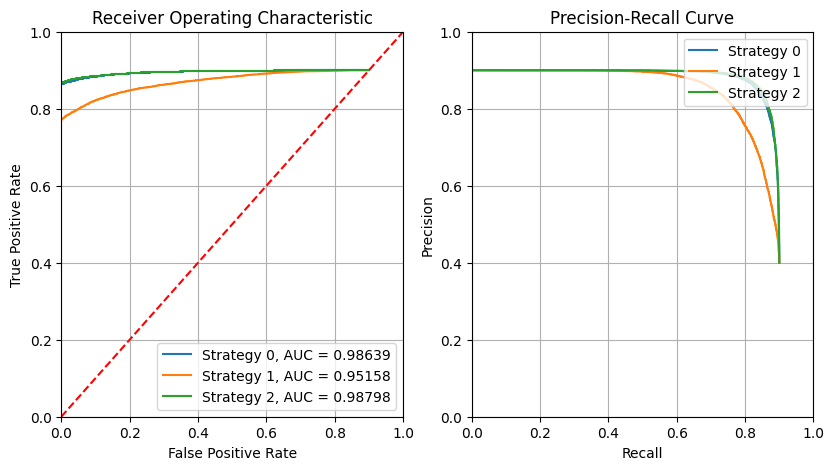

In [ ]:
g4_np_data_path = '/content/Real_ZDNA.fasta.npy'
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/generated_sequences_ZDNA_vavae (1).fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.01
    beta_1 = 0.99
    beta_2 = 0.99
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 1
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

# Plot ROC curves for each strategy
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic')
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    plt.plot(fpr_list[i] - 0.1, tpr_list[i] - 0.1, label=f'Strategy {strategy}, AUC = {roc_auc:.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i] - 0.1, precision_list[i]- 0.1, label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1 Score: {f1_score:.5f}")

Strategy 0 - ROC AUC: 0.98639, Precision: 0.79776, Recall: 0.88300, F1 Score: 0.94233
Strategy 1 - ROC AUC: 0.95158, Precision: 0.78839, Recall: 0.83840, F1 Score: 0.88527
Strategy 2 - ROC AUC: 0.98798, Precision: 0.81253, Recall: 0.84673, F1 Score: 0.94784


[1,    10] loss: 0.706 acc: 0.498
[1,    20] loss: 0.698 acc: 0.487
[1,    30] loss: 0.697 acc: 0.483
[1,    40] loss: 0.693 acc: 0.505
[1,    50] loss: 0.689 acc: 0.579
[1,    60] loss: 0.664 acc: 0.545
[1,    70] loss: 0.622 acc: 0.471
[1,    80] loss: 0.548 acc: 0.681
[1,    90] loss: 0.506 acc: 0.815
[1,   100] loss: 0.457 acc: 0.860
[1,   110] loss: 0.453 acc: 0.859
[1,   120] loss: 0.443 acc: 0.851
[1,   130] loss: 0.418 acc: 0.869
[1,   140] loss: 0.407 acc: 0.850
[1,   150] loss: 0.407 acc: 0.852
[1,   160] loss: 0.415 acc: 0.851
[1,   170] loss: 0.390 acc: 0.877
[1,   180] loss: 0.375 acc: 0.870
[1,   190] loss: 0.362 acc: 0.873
[1,   200] loss: 0.342 acc: 0.882
[1,   210] loss: 0.324 acc: 0.894
[1,   220] loss: 0.317 acc: 0.879
[1,   230] loss: 0.298 acc: 0.894
[1,   240] loss: 0.269 acc: 0.916
[1,   250] loss: 0.272 acc: 0.902
[1,   260] loss: 0.261 acc: 0.912
[1,   270] loss: 0.269 acc: 0.895
[1,   280] loss: 0.274 acc: 0.905
[1,   290] loss: 0.259 acc: 0.909
[1,   300] los

Text(0.5, 0, 'Recall')

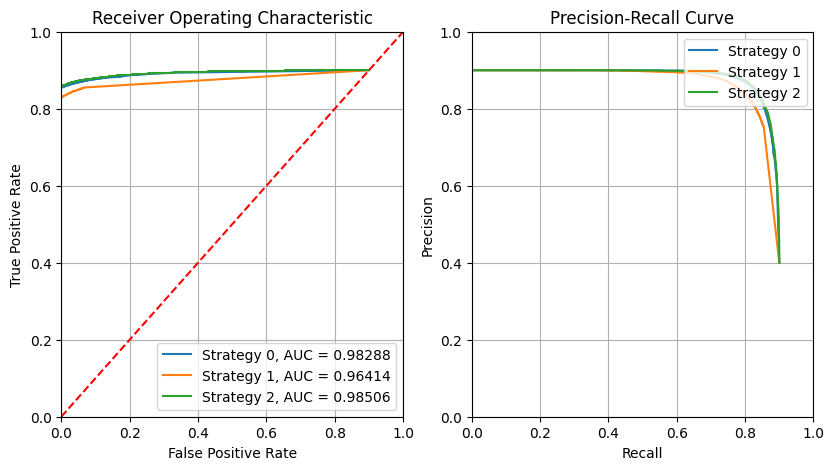

In [ ]:
g4_np_data_path = '/content/Real_F.fasta.npy'
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/diff_generated_sequences_fulldata.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.01
    beta_1 = 0.99
    beta_2 = 0.99
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 1
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

# Plot ROC curves for each strategy
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic')
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    plt.plot(fpr_list[i] - 0.1, tpr_list[i] - 0.1, label=f'Strategy {strategy}, AUC = {roc_auc:.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i] - 0.1, precision_list[i]- 0.1, label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1 Score: {f1_score:.5f}")

Strategy 0 - ROC AUC: 0.98288, Precision: 0.92703, Recall: 0.75175, F1 Score: 0.93954
Strategy 1 - ROC AUC: 0.96414, Precision: 0.97522, Recall: 0.61367, F1 Score: 0.91931
Strategy 2 - ROC AUC: 0.98506, Precision: 0.79846, Recall: 0.87894, F1 Score: 0.94061


[1,    10] loss: 0.696 acc: 0.510
[1,    20] loss: 0.694 acc: 0.512
[1,    30] loss: 0.693 acc: 0.480
[1,    40] loss: 0.692 acc: 0.564
[1,    50] loss: 0.691 acc: 0.670
[1,    60] loss: 0.690 acc: 0.679
[1,    70] loss: 0.689 acc: 0.755
[1,    80] loss: 0.688 acc: 0.709
[1,    90] loss: 0.688 acc: 0.515
[1,   100] loss: 0.687 acc: 0.701
[1,   110] loss: 0.686 acc: 0.624
[1,   120] loss: 0.685 acc: 0.695
[1,   130] loss: 0.683 acc: 0.731
[1,   140] loss: 0.682 acc: 0.754
[1,   150] loss: 0.682 acc: 0.768
[1,   160] loss: 0.680 acc: 0.773
[1,   170] loss: 0.679 acc: 0.795
[1,   180] loss: 0.678 acc: 0.816
[1,   190] loss: 0.678 acc: 0.632
[1,   200] loss: 0.675 acc: 0.839
[1,   210] loss: 0.673 acc: 0.806
[1,   220] loss: 0.674 acc: 0.748
[1,   230] loss: 0.669 acc: 0.803
[1,   240] loss: 0.670 acc: 0.780
[1,   250] loss: 0.668 acc: 0.804
[1,   260] loss: 0.665 acc: 0.794
[1,   270] loss: 0.664 acc: 0.820
[1,   280] loss: 0.661 acc: 0.802
[1,   290] loss: 0.660 acc: 0.759
[1,   300] los

Text(0.5, 0, 'Recall')

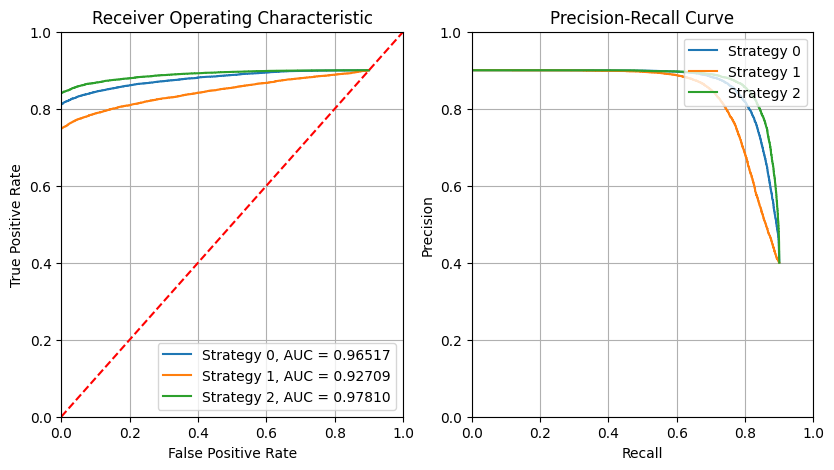

In [ ]:
g4_np_data_path = '/content/Real_F.fasta.npy'
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/generated_sequences_vqvae_fulldata.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.0001
    beta_1 = 0.9
    beta_2 = 0.99
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

# Plot ROC curves for each strategy
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic')
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    plt.plot(fpr_list[i] - 0.1, tpr_list[i] - 0.1, label=f'Strategy {strategy}, AUC = {roc_auc:.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i] - 0.1, precision_list[i]- 0.1, label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1 Score: {f1_score:.5f}")

[1,    10] loss: 0.690 acc: 0.512
[1,    20] loss: 0.690 acc: 0.567
[1,    30] loss: 0.688 acc: 0.570
[1,    40] loss: 0.687 acc: 0.729
[1,    50] loss: 0.686 acc: 0.769
[1,    60] loss: 0.684 acc: 0.805
[1,    70] loss: 0.684 acc: 0.693
[1,    80] loss: 0.682 acc: 0.766
[1,    90] loss: 0.681 acc: 0.635
[1,   100] loss: 0.680 acc: 0.742
[1,   110] loss: 0.678 acc: 0.657
[1,   120] loss: 0.677 acc: 0.704
[1,   130] loss: 0.675 acc: 0.777
[1,   140] loss: 0.674 acc: 0.780
[1,   150] loss: 0.670 acc: 0.813
[1,   160] loss: 0.671 acc: 0.712
[1,   170] loss: 0.669 acc: 0.811
[1,   180] loss: 0.668 acc: 0.681
[1,   190] loss: 0.664 acc: 0.809
[1,   200] loss: 0.662 acc: 0.824
[1,   210] loss: 0.661 acc: 0.845
[1,   220] loss: 0.657 acc: 0.830
[1,   230] loss: 0.656 acc: 0.835
[1,   240] loss: 0.655 acc: 0.844
[1,   250] loss: 0.650 acc: 0.870
[1,   260] loss: 0.648 acc: 0.829
[1,   270] loss: 0.644 acc: 0.828
[1,   280] loss: 0.643 acc: 0.847
[1,   290] loss: 0.639 acc: 0.847
[1,   300] los

Text(0.5, 0, 'Recall')

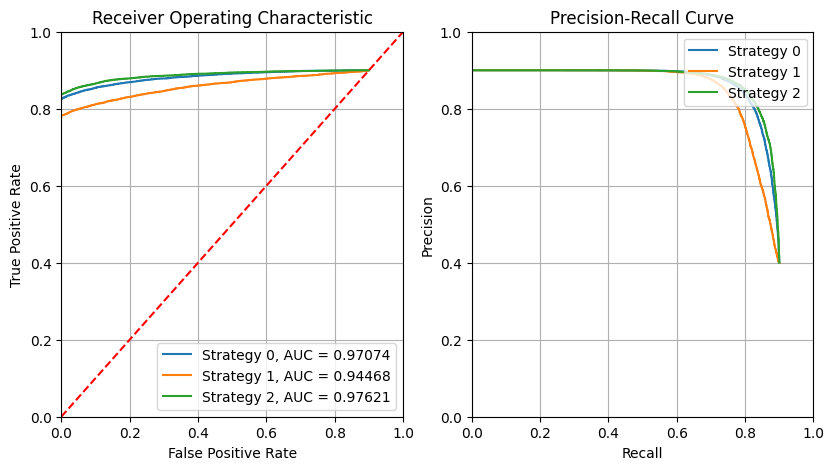

In [ ]:
g4_np_data_path = '/content/Real_F.fasta.npy'
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/wgan_generated_sequences_fulldata.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.0001
    beta_1 = 0.9
    beta_2 = 0.99
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

# Plot ROC curves for each strategy
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic')
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    plt.plot(fpr_list[i] - 0.1, tpr_list[i] - 0.1, label=f'Strategy {strategy}, AUC = {roc_auc:.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i] - 0.1, precision_list[i]- 0.1, label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1 Score: {f1_score:.5f}")

[1,    10] loss: 0.685 acc: 0.588
[1,    20] loss: 0.675 acc: 0.569
[1,    30] loss: 0.652 acc: 0.623
[1,    40] loss: 0.613 acc: 0.671
[1,    50] loss: 0.539 acc: 0.814
[1,    60] loss: 0.435 acc: 0.938
[1,    70] loss: 0.362 acc: 0.892
[1,    80] loss: 0.299 acc: 0.924
[1,    90] loss: 0.238 acc: 0.948
[1,   100] loss: 0.204 acc: 0.935
[1,   110] loss: 0.854 acc: 0.959
[1,   120] loss: 0.121 acc: 0.959
[1,   130] loss: 0.250 acc: 0.938
[1,   140] loss: 0.228 acc: 0.958
[1,   150] loss: 0.269 acc: 0.965
[1,   160] loss: 0.188 acc: 0.966
[1,   170] loss: 0.266 acc: 0.967
[1,   180] loss: 0.435 acc: 0.952
[1,   190] loss: 0.580 acc: 0.963
[1,   200] loss: 1.254 acc: 0.962
[1,   210] loss: 1.761 acc: 0.942
[1,   220] loss: 2.594 acc: 0.940
[1,   230] loss: 2.902 acc: 0.941
[1,   240] loss: 3.636 acc: 0.921
[1,   250] loss: 4.157 acc: 0.933
[1,   260] loss: 5.007 acc: 0.923
[1,   270] loss: 5.313 acc: 0.923
[1,   280] loss: 6.379 acc: 0.920
[1,   290] loss: 5.599 acc: 0.925
[1,   300] los

Text(0.5, 0, 'Recall')

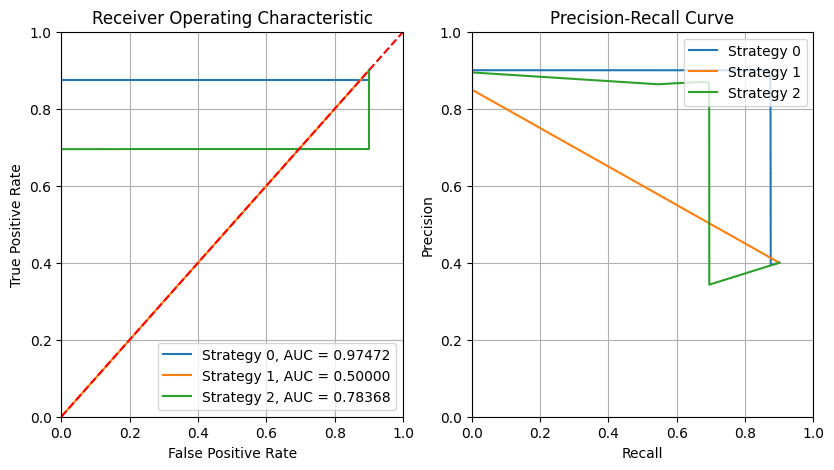

In [ ]:
g4_np_data_path = '/content/Real_ZDNA.fasta.npy'
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/generated_wgan_ZDNA (1).fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.005
    beta_1 = 0.95
    beta_2 = 0.75
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

# Plot ROC curves for each strategy
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic')
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    plt.plot(fpr_list[i] - 0.1, tpr_list[i] - 0.1, label=f'Strategy {strategy}, AUC = {roc_auc:.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i] - 0.1, precision_list[i]- 0.1, label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1 Score: {f1_score:.5f}")

Strategy 0 - ROC AUC: 0.97472, Precision: 0.70667, Recall: 0.97264, F1 Score: 0.98374
Strategy 1 - ROC AUC: 0.50000, Precision: 0.75000, Recall: 0.50000, F1 Score: 0.66667
Strategy 2 - ROC AUC: 0.78368, Precision: 0.65831, Recall: 0.79322, F1 Score: 0.87147


# Curax

In [ ]:
files = [
    "curax_filter-norm_to_500.fasta",
    "curax_diff.fasta",
    "curax_wgan.fasta",
    "curax_vqvae.fasta",
]

In [ ]:
for file in files:
    # Normalisation
    one_hot_quads = []
    line_num = 0
    with open(file, 'r') as f:
      for line in f:
        if line[0] != '>':
          one_hot = []
          for s in line.upper():
            if s != '\n':
              one_hot.append(codes[s])
          one_hot_quads.append(one_hot)
          line_num += 1
    one_hot_quads_np = np.array(one_hot_quads)
    print(f'Shape of {file}', one_hot_quads_np.shape)
    np.save(f'{file}.npy', one_hot_quads_np)

Shape of curax_filter-norm_to_500.fasta (1484, 512, 5)
Shape of curax_diff.fasta (1500, 100, 5)
Shape of curax_wgan.fasta (1484, 100, 5)
Shape of curax_vqvae.fasta (1387, 100, 5)


In [ ]:
input_fake = np.load('/content/curax_diff.fasta.npy')

[1,    10] loss: 0.687 acc: 0.535
[2,    10] loss: 0.549 acc: 0.820
[3,    10] loss: 0.256 acc: 0.920
[4,    10] loss: 0.195 acc: 0.925
[5,    10] loss: 0.151 acc: 0.942
[1,    10] loss: 0.703 acc: 0.505
[2,    10] loss: 0.681 acc: 0.495
[3,    10] loss: 0.565 acc: 0.695
[4,    10] loss: 0.450 acc: 0.847
[5,    10] loss: 0.420 acc: 0.863
[1,    10] loss: 0.704 acc: 0.537
[1,    20] loss: 0.650 acc: 0.702
[1,    30] loss: 0.564 acc: 0.820
[2,    10] loss: 0.335 acc: 0.920
[2,    20] loss: 0.218 acc: 0.920
[2,    30] loss: 0.206 acc: 0.912
[3,    10] loss: 0.171 acc: 0.941
[3,    20] loss: 0.168 acc: 0.941
[3,    30] loss: 0.160 acc: 0.948
[4,    10] loss: 0.212 acc: 0.922
[4,    20] loss: 0.180 acc: 0.937
[4,    30] loss: 0.230 acc: 0.928
[5,    10] loss: 0.176 acc: 0.936
[5,    20] loss: 0.144 acc: 0.949
[5,    30] loss: 0.140 acc: 0.949


Text(0.5, 0, 'Recall')

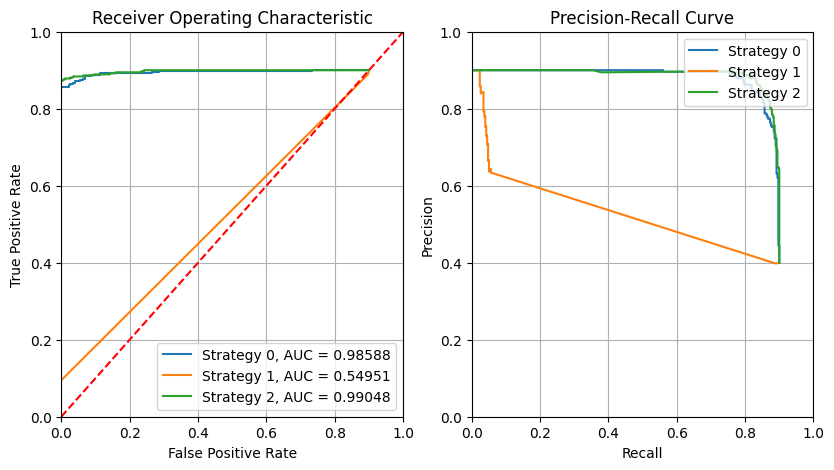

In [ ]:
g4_np_data_path = '/content/curax_filter-norm_to_500.fasta.npy'
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/curax_diff.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.01
    beta_1 = 0.99
    beta_2 = 0.99
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

# Plot ROC curves for each strategy
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic')
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    plt.plot(fpr_list[i] - 0.1, tpr_list[i] - 0.1, label=f'Strategy {strategy}, AUC = {roc_auc:.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i] - 0.1, precision_list[i]- 0.1, label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1 Score: {f1_score:.5f}")

Strategy 0 - ROC AUC: 0.98588, Precision: 0.78359, Recall: 0.91029, F1 Score: 0.94213
Strategy 1 - ROC AUC: 0.54951, Precision: 0.89997, Recall: 0.14215, F1 Score: 0.66667
Strategy 2 - ROC AUC: 0.99048, Precision: 0.78775, Recall: 0.90973, F1 Score: 0.95436


In [ ]:
input_fake = np.load('/content/curax_wgan.fasta.npy')

[1,    10] loss: 0.705 acc: 0.486
[2,    10] loss: 0.658 acc: 0.535
[3,    10] loss: 0.558 acc: 0.704
[4,    10] loss: 0.435 acc: 0.907
[5,    10] loss: 0.361 acc: 0.939
[1,    10] loss: 0.713 acc: 0.493
[2,    10] loss: 0.694 acc: 0.498
[3,    10] loss: 0.693 acc: 0.493
[4,    10] loss: 0.693 acc: 0.501
[5,    10] loss: 0.693 acc: 0.500
[1,    10] loss: 0.699 acc: 0.512
[1,    20] loss: 0.678 acc: 0.532
[1,    30] loss: 0.674 acc: 0.580
[2,    10] loss: 0.617 acc: 0.783
[2,    20] loss: 0.546 acc: 0.789
[2,    30] loss: 0.447 acc: 0.826
[3,    10] loss: 0.312 acc: 0.880
[3,    20] loss: 0.267 acc: 0.899
[3,    30] loss: 0.253 acc: 0.911
[4,    10] loss: 0.218 acc: 0.917
[4,    20] loss: 0.225 acc: 0.915
[4,    30] loss: 0.203 acc: 0.920
[5,    10] loss: 0.222 acc: 0.909
[5,    20] loss: 0.152 acc: 0.946
[5,    30] loss: 0.170 acc: 0.937


Text(0.5, 0, 'Recall')

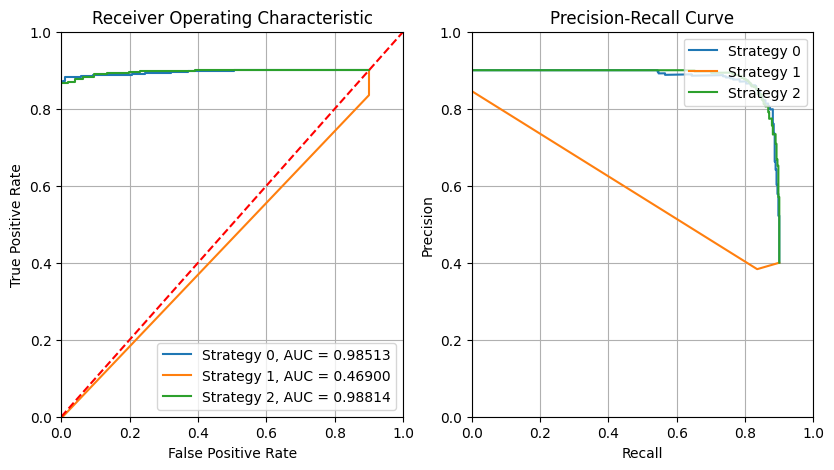

In [ ]:
g4_np_data_path = '/content/curax_filter-norm_to_500.fasta.npy'
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/curax_wgan.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.01
    beta_1 = 0.99
    beta_2 = 0.99
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

# Plot ROC curves for each strategy
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic')
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    plt.plot(fpr_list[i] - 0.1, tpr_list[i] - 0.1, label=f'Strategy {strategy}, AUC = {roc_auc:.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i] - 0.1, precision_list[i]- 0.1, label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1 Score: {f1_score:.5f}")

Strategy 0 - ROC AUC: 0.98513, Precision: 0.82423, Recall: 0.79561, F1 Score: 0.94595
Strategy 1 - ROC AUC: 0.46900, Precision: 0.74582, Recall: 0.48450, F1 Score: 0.66667
Strategy 2 - ROC AUC: 0.98814, Precision: 0.82444, Recall: 0.80203, F1 Score: 0.94437


In [ ]:
input_fake = np.load('/content/curax_vqvae.fasta.npy')

[1,    10] loss: 0.719 acc: 0.514
[2,    10] loss: 0.661 acc: 0.581
[3,    10] loss: 0.456 acc: 0.852
[4,    10] loss: 0.247 acc: 0.916
[5,    10] loss: 0.193 acc: 0.924
[1,    10] loss: 0.697 acc: 0.526
[2,    10] loss: 0.632 acc: 0.755
[3,    10] loss: 0.510 acc: 0.806
[4,    10] loss: 0.439 acc: 0.842
[5,    10] loss: 0.416 acc: 0.861
[1,    10] loss: 0.706 acc: 0.491
[1,    20] loss: 0.683 acc: 0.541
[1,    30] loss: 0.674 acc: 0.541
[2,    10] loss: 0.649 acc: 0.609
[2,    20] loss: 0.603 acc: 0.805
[2,    30] loss: 0.507 acc: 0.844
[3,    10] loss: 0.328 acc: 0.884
[3,    20] loss: 0.263 acc: 0.891
[3,    30] loss: 0.240 acc: 0.900
[4,    10] loss: 0.215 acc: 0.916
[4,    20] loss: 0.212 acc: 0.915
[4,    30] loss: 0.245 acc: 0.909
[5,    10] loss: 0.185 acc: 0.933
[5,    20] loss: 0.162 acc: 0.939
[5,    30] loss: 0.219 acc: 0.924


Text(0.5, 0, 'Recall')

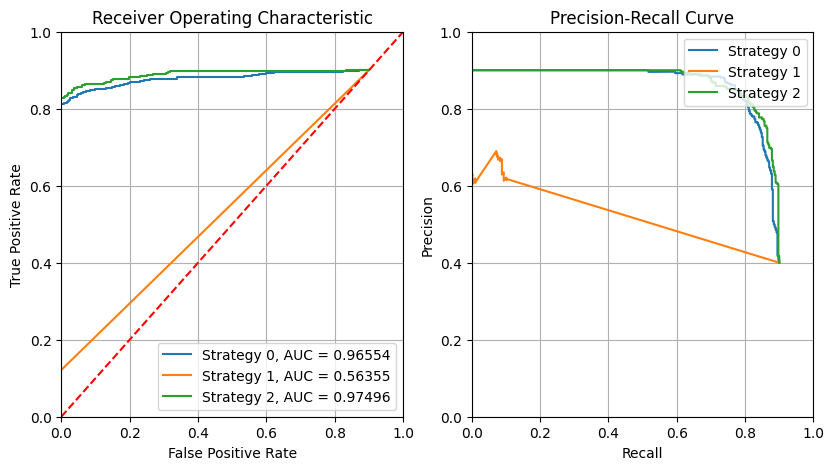

In [ ]:
g4_np_data_path = '/content/curax_filter-norm_to_500.fasta.npy'
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/curax_wgan.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.01
    beta_1 = 0.99
    beta_2 = 0.99
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

# Plot ROC curves for each strategy
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic')
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    plt.plot(fpr_list[i] - 0.1, tpr_list[i] - 0.1, label=f'Strategy {strategy}, AUC = {roc_auc:.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i] - 0.1, precision_list[i]- 0.1, label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1 Score: {f1_score:.5f}")

Strategy 0 - ROC AUC: 0.96554, Precision: 0.80360, Recall: 0.81878, F1 Score: 0.91516
Strategy 1 - ROC AUC: 0.56355, Precision: 0.79360, Recall: 0.10961, F1 Score: 0.66667
Strategy 2 - ROC AUC: 0.97496, Precision: 0.81944, Recall: 0.79164, F1 Score: 0.91951


# t

In [ ]:
file_1 = "/content/diff_generated_sequences_1.fasta"
file_10 = "/content/diff_generated_sequences_10.fasta"
file_100 = "/content/diff_generated_sequences_1000.fasta"
file_1000 = "/content/diff_generated_sequences_1000.fasta"
real = "/content/diff_generated_G4.fasta"

In [ ]:
files_t = [
            file_1,
            file_10,
            file_100,
            file_1000,
            real
]

In [ ]:
for file in files_t:
    # Normalisation
    one_hot_quads = []
    line_num = 0
    with open(file, 'r') as f:
      for line in f:
        if line[0] != '>':
          one_hot = []
          for s in line.upper():
            if s != '\n':
              one_hot.append(codes[s])
          one_hot_quads.append(one_hot)
          line_num += 1
    one_hot_quads_np = np.array(one_hot_quads)
    print(f'Shape of {file}', one_hot_quads_np.shape)
    np.save(f'{file}.npy', one_hot_quads_np)

Shape of /content/diff_generated_sequences_1.fasta (15996, 100, 5)
Shape of /content/diff_generated_sequences_10.fasta (15996, 100, 5)
Shape of /content/diff_generated_sequences_1000.fasta (15996, 100, 5)
Shape of /content/diff_generated_sequences_1000.fasta (15996, 100, 5)
Shape of /content/diff_generated_G4.fasta (8764, 100, 5)


t=1

In [ ]:
g4_np_data_path = '/content/diff_generated_G4.fasta.npy'
input_fake = np.load('/content/diff_generated_sequences_1.fasta.npy')
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/diff_generated_sequences_1.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.005
    beta_1 = 0.95
    beta_2 = 0.75
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

[1,    10] loss: 0.694 acc: 0.512
[1,    20] loss: 0.684 acc: 0.599
[1,    30] loss: 0.667 acc: 0.613
[1,    40] loss: 0.636 acc: 0.751
[1,    50] loss: 0.588 acc: 0.770
[1,    60] loss: 0.542 acc: 0.730
[1,    70] loss: 0.462 acc: 0.829
[1,    80] loss: 0.427 acc: 0.831
[1,    90] loss: 0.390 acc: 0.852
[1,   100] loss: 0.339 acc: 0.859
[2,    10] loss: 0.343 acc: 0.856
[2,    20] loss: 0.507 acc: 0.845
[2,    30] loss: 0.726 acc: 0.855
[2,    40] loss: 1.045 acc: 0.845
[2,    50] loss: 1.018 acc: 0.860
[2,    60] loss: 1.238 acc: 0.869
[2,    70] loss: 2.407 acc: 0.851
[2,    80] loss: 2.328 acc: 0.855
[2,    90] loss: 1.776 acc: 0.856
[2,   100] loss: 2.152 acc: 0.869
[3,    10] loss: 2.890 acc: 0.870
[3,    20] loss: 2.426 acc: 0.884
[3,    30] loss: 2.637 acc: 0.887
[3,    40] loss: 2.546 acc: 0.889
[3,    50] loss: 3.707 acc: 0.880
[3,    60] loss: 3.799 acc: 0.881
[3,    70] loss: 4.719 acc: 0.879
[3,    80] loss: 4.482 acc: 0.876
[3,    90] loss: 3.937 acc: 0.886
[3,   100] los

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1_score:.3f}")

Strategy 0 - ROC AUC: 0.771, Precision: 0.775, Recall: 0.649, F1 Score: 0.818
Strategy 1 - ROC AUC: 0.500, Precision: 0.750, Recall: 0.500, F1 Score: 0.667
Strategy 2 - ROC AUC: 0.978, Precision: 0.814, Recall: 0.828, F1 Score: 0.940


t=10

In [ ]:
g4_np_data_path = '/content/diff_generated_G4.fasta.npy'
input_fake = np.load('/content/diff_generated_sequences_10.fasta.npy')
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/diff_generated_sequences_10.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.005
    beta_1 = 0.95
    beta_2 = 0.75
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

[1,    10] loss: 0.699 acc: 0.519
[1,    20] loss: 0.687 acc: 0.520
[1,    30] loss: 0.663 acc: 0.616
[1,    40] loss: 0.636 acc: 0.567
[1,    50] loss: 0.579 acc: 0.819
[1,    60] loss: 0.506 acc: 0.838
[1,    70] loss: 0.445 acc: 0.831
[1,    80] loss: 0.377 acc: 0.858
[1,    90] loss: 0.392 acc: 0.841
[1,   100] loss: 0.369 acc: 0.852
[2,    10] loss: 0.345 acc: 0.856
[2,    20] loss: 0.316 acc: 0.874
[2,    30] loss: 0.295 acc: 0.883
[2,    40] loss: 0.364 acc: 0.882
[2,    50] loss: 0.264 acc: 0.886
[2,    60] loss: 0.340 acc: 0.895
[2,    70] loss: 0.463 acc: 0.912
[2,    80] loss: 0.384 acc: 0.902
[2,    90] loss: 0.606 acc: 0.907
[2,   100] loss: 0.673 acc: 0.911
[3,    10] loss: 1.006 acc: 0.901
[3,    20] loss: 0.747 acc: 0.914
[3,    30] loss: 1.453 acc: 0.912
[3,    40] loss: 1.266 acc: 0.913
[3,    50] loss: 1.592 acc: 0.909
[3,    60] loss: 1.117 acc: 0.920
[3,    70] loss: 1.657 acc: 0.910
[3,    80] loss: 1.808 acc: 0.913
[3,    90] loss: 1.193 acc: 0.920
[3,   100] los

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1_score:.3f}")

Strategy 0 - ROC AUC: 0.982, Precision: 0.823, Recall: 0.803, F1 Score: 0.933
Strategy 1 - ROC AUC: 0.724, Precision: 0.723, Recall: 0.626, F1 Score: 0.699
Strategy 2 - ROC AUC: 0.967, Precision: 0.832, Recall: 0.734, F1 Score: 0.913


t=100

In [ ]:
g4_np_data_path = '/content/diff_generated_G4.fasta.npy'
input_fake = np.load('/content/diff_generated_sequences_1000.fasta.npy')
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/diff_generated_sequences_1000.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.005
    beta_1 = 0.95
    beta_2 = 0.75
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

[1,    10] loss: 0.687 acc: 0.548
[1,    20] loss: 0.657 acc: 0.642
[1,    30] loss: 0.611 acc: 0.691
[1,    40] loss: 0.536 acc: 0.798
[1,    50] loss: 0.468 acc: 0.845
[1,    60] loss: 0.399 acc: 0.841
[1,    70] loss: 0.369 acc: 0.845
[1,    80] loss: 0.380 acc: 0.856
[1,    90] loss: 0.342 acc: 0.870
[1,   100] loss: 0.325 acc: 0.869
[2,    10] loss: 0.302 acc: 0.882
[2,    20] loss: 0.295 acc: 0.880
[2,    30] loss: 0.248 acc: 0.912
[2,    40] loss: 0.246 acc: 0.905
[2,    50] loss: 0.283 acc: 0.923
[2,    60] loss: 0.302 acc: 0.907
[2,    70] loss: 0.394 acc: 0.902
[2,    80] loss: 0.198 acc: 0.927
[2,    90] loss: 0.384 acc: 0.901
[2,   100] loss: 0.228 acc: 0.903
[3,    10] loss: 0.199 acc: 0.920
[3,    20] loss: 0.366 acc: 0.910
[3,    30] loss: 0.423 acc: 0.921
[3,    40] loss: 0.497 acc: 0.921
[3,    50] loss: 0.548 acc: 0.931
[3,    60] loss: 0.642 acc: 0.927
[3,    70] loss: 0.315 acc: 0.930
[3,    80] loss: 0.592 acc: 0.934
[3,    90] loss: 0.474 acc: 0.932
[3,   100] los

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1_score:.3f}")

Strategy 0 - ROC AUC: 0.976, Precision: 0.838, Recall: 0.739, F1 Score: 0.940
Strategy 1 - ROC AUC: 0.872, Precision: 0.804, Recall: 0.712, F1 Score: 0.880
Strategy 2 - ROC AUC: 0.978, Precision: 0.813, Recall: 0.831, F1 Score: 0.936


t=1000

In [ ]:
g4_np_data_path = '/content/diff_generated_G4.fasta.npy'
input_fake = np.load('/content/diff_generated_sequences_1000.fasta.npy')
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/diff_generated_sequences_1000.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.005
    beta_1 = 0.95
    beta_2 = 0.75
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

[1,    10] loss: 0.687 acc: 0.508
[1,    20] loss: 0.659 acc: 0.596
[1,    30] loss: 0.623 acc: 0.702
[1,    40] loss: 0.572 acc: 0.762
[1,    50] loss: 0.518 acc: 0.789
[1,    60] loss: 0.477 acc: 0.805
[1,    70] loss: 0.441 acc: 0.820
[1,    80] loss: 0.449 acc: 0.816
[1,    90] loss: 0.395 acc: 0.837
[1,   100] loss: 0.356 acc: 0.872
[2,    10] loss: 0.336 acc: 0.861
[2,    20] loss: 0.332 acc: 0.875
[2,    30] loss: 0.325 acc: 0.871
[2,    40] loss: 0.353 acc: 0.885
[2,    50] loss: 0.307 acc: 0.873
[2,    60] loss: 0.444 acc: 0.881
[2,    70] loss: 0.487 acc: 0.866
[2,    80] loss: 0.362 acc: 0.879
[2,    90] loss: 0.410 acc: 0.902
[2,   100] loss: 0.324 acc: 0.899
[3,    10] loss: 0.454 acc: 0.920
[3,    20] loss: 0.364 acc: 0.914
[3,    30] loss: 0.344 acc: 0.914
[3,    40] loss: 0.243 acc: 0.934
[3,    50] loss: 0.659 acc: 0.912
[3,    60] loss: 0.492 acc: 0.930
[3,    70] loss: 0.481 acc: 0.930
[3,    80] loss: 0.318 acc: 0.938
[3,    90] loss: 0.637 acc: 0.925
[3,   100] los

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1_score:.3f}")

Strategy 0 - ROC AUC: 0.958, Precision: 0.826, Recall: 0.758, F1 Score: 0.931
Strategy 1 - ROC AUC: 0.985, Precision: 0.769, Recall: 0.935, F1 Score: 0.946
Strategy 2 - ROC AUC: 0.969, Precision: 0.826, Recall: 0.777, F1 Score: 0.940


dist

In [ ]:
file_real = "/content/diff_generated_G4.fasta"
file_1 = "/content/diff_generated_sequences_x2.fasta"
file_2 = "/content/diff_generated_sequences_x4.fasta"

In [ ]:
files_dist = [
              file_real,
              file_1,
              file_2

]

In [ ]:
for file in files_dist:
    # Normalisation
    one_hot_quads = []
    line_num = 0
    with open(file, 'r') as f:
      for line in f:
        if line[0] != '>':
          one_hot = []
          for s in line.upper():
            if s != '\n':
              one_hot.append(codes[s])
          one_hot_quads.append(one_hot)
          line_num += 1
    one_hot_quads_np = np.array(one_hot_quads)
    print(f'Shape of {file}', one_hot_quads_np.shape)
    np.save(f'{file}.npy', one_hot_quads_np)

Shape of /content/diff_generated_G4.fasta (8764, 100, 5)
Shape of /content/diff_generated_sequences_x2.fasta (15996, 100, 5)
Shape of /content/diff_generated_sequences_x4.fasta (15996, 100, 5)


In [ ]:
g4_np_data_path = '/content/diff_generated_G4.fasta.npy'
input_fake = np.load('/content/diff_generated_G4.fasta.npy')
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/diff_generated_G4.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.005
    beta_1 = 0.95
    beta_2 = 0.75
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

[1,    10] loss: 0.672 acc: 0.621
[1,    20] loss: 0.608 acc: 0.754
[1,    30] loss: 0.509 acc: 0.820
[1,    40] loss: 0.426 acc: 0.860
[1,    50] loss: 0.370 acc: 0.858
[1,    60] loss: 0.342 acc: 0.864
[1,    70] loss: 0.309 acc: 0.882
[1,    80] loss: 0.296 acc: 0.881
[1,    90] loss: 0.264 acc: 0.905
[1,   100] loss: 0.239 acc: 0.906
[2,    10] loss: 0.369 acc: 0.909
[2,    20] loss: 0.222 acc: 0.909
[2,    30] loss: 0.524 acc: 0.908
[2,    40] loss: 0.185 acc: 0.927
[2,    50] loss: 0.188 acc: 0.924
[2,    60] loss: 0.172 acc: 0.926
[2,    70] loss: 0.181 acc: 0.923
[2,    80] loss: 0.158 acc: 0.935
[2,    90] loss: 0.163 acc: 0.934
[2,   100] loss: 0.149 acc: 0.941
[3,    10] loss: 0.164 acc: 0.932
[3,    20] loss: 0.166 acc: 0.937
[3,    30] loss: 0.170 acc: 0.927
[3,    40] loss: 0.177 acc: 0.939
[3,    50] loss: 0.142 acc: 0.938
[3,    60] loss: 0.212 acc: 0.929
[3,    70] loss: 0.303 acc: 0.936
[3,    80] loss: 0.277 acc: 0.923
[3,    90] loss: 0.254 acc: 0.928
[3,   100] los

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1_score:.3f}")

Strategy 0 - ROC AUC: 0.500, Precision: 0.750, Recall: 0.500, F1 Score: 0.667
Strategy 1 - ROC AUC: 0.981, Precision: 0.819, Recall: 0.812, F1 Score: 0.936
Strategy 2 - ROC AUC: 0.985, Precision: 0.821, Recall: 0.812, F1 Score: 0.939


In [ ]:
g4_np_data_path = '/content/diff_generated_G4.fasta.npy'
input_fake = np.load('/content/diff_generated_sequences_x4.fasta.npy')
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/diff_generated_sequences_x4.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.005
    beta_1 = 0.95
    beta_2 = 0.75
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

[1,    10] loss: 0.690 acc: 0.577
[1,    20] loss: 0.655 acc: 0.639
[1,    30] loss: 0.583 acc: 0.788
[1,    40] loss: 0.519 acc: 0.805
[1,    50] loss: 0.457 acc: 0.809
[1,    60] loss: 0.392 acc: 0.850
[1,    70] loss: 0.375 acc: 0.845
[1,    80] loss: 0.353 acc: 0.841
[1,    90] loss: 0.344 acc: 0.855
[1,   100] loss: 0.323 acc: 0.863
[2,    10] loss: 0.283 acc: 0.888
[2,    20] loss: 0.275 acc: 0.881
[2,    30] loss: 0.241 acc: 0.909
[2,    40] loss: 0.322 acc: 0.896
[2,    50] loss: 0.211 acc: 0.917
[2,    60] loss: 0.195 acc: 0.923
[2,    70] loss: 0.211 acc: 0.910
[2,    80] loss: 0.210 acc: 0.910
[2,    90] loss: 0.172 acc: 0.928
[2,   100] loss: 0.181 acc: 0.919
[3,    10] loss: 0.211 acc: 0.916
[3,    20] loss: 0.264 acc: 0.925
[3,    30] loss: 0.169 acc: 0.932
[3,    40] loss: 0.416 acc: 0.928
[3,    50] loss: 0.247 acc: 0.930
[3,    60] loss: 0.309 acc: 0.940
[3,    70] loss: 0.175 acc: 0.929
[3,    80] loss: 0.336 acc: 0.928
[3,    90] loss: 0.157 acc: 0.933
[3,   100] los

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1_score:.3f}")

Strategy 0 - ROC AUC: 0.966, Precision: 0.808, Recall: 0.830, F1 Score: 0.931
Strategy 1 - ROC AUC: 0.388, Precision: 0.617, Recall: 0.421, F1 Score: 0.667
Strategy 2 - ROC AUC: 0.873, Precision: 0.988, Recall: 0.581, F1 Score: 0.885


# H-DNA

In [ ]:
real_HDNA = "/content/drive/My Drive/data_for_gans/HDNA_filter-norm_to_500.fasta"
# diff_HDNA = "/content/HDNA_diff.fasta"
# wgan_HDNA = "/content/HDNA_wgan.fasta"
vae_HDNA = "/content/HDNA_vqvae.fasta"

In [ ]:
HDNA_files =[
        #  real_HDNA,
        #  diff_HDNA,
        #  wgan_HDNA,
         vae_HDNA,
]

In [ ]:
for file in HDNA_files:
    # Normalisation
    one_hot_quads = []
    line_num = 0
    with open(file, 'r') as f:
      for line in f:
        if line[0] != '>':
          one_hot = []
          for s in line.upper():
            if s != '\n':
              one_hot.append(codes[s])
          one_hot_quads.append(one_hot)
          line_num += 1
    one_hot_quads_np = np.array(one_hot_quads)
    print(f'Shape of {file}', one_hot_quads_np.shape)
    np.save(f'{file}.npy', one_hot_quads_np)

Shape of /content/HDNA_vqvae.fasta (704823, 100, 5)


In [ ]:
one_hot_quads = []
line_num = 0
with open("/content/drive/My Drive/data_for_gans/HDNA_filter-norm_to_500.fasta", 'r') as f:
  for line in f:
    if line[0] != '>':
      one_hot = []
      for s in line.upper():
        if s != '\n':
          one_hot.append(codes[s])
      one_hot_quads.append(one_hot)
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
print(f'Shape', one_hot_quads_np.shape)
np.save(f'real.npy', one_hot_quads_np)

Shape (704830, 512, 5)


In [ ]:
g4_np_data_path = 'real.npy'
input_fake = np.load('/content/HDNA_diff.fasta.npy')
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/HDNA_diff.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.005
    beta_1 = 0.95
    beta_2 = 0.75
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 100
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

[1,   100] loss: 0.682 acc: 0.561
[1,   200] loss: 0.533 acc: 0.868
[1,   300] loss: 0.741 acc: 0.937
[1,   400] loss: 0.873 acc: 0.946
[1,   500] loss: 1.112 acc: 0.954
[1,   600] loss: 1.083 acc: 0.944
[1,   700] loss: 1.063 acc: 0.952
[1,   800] loss: 0.940 acc: 0.953
[1,   900] loss: 1.064 acc: 0.953
[1,  1000] loss: 0.976 acc: 0.947
[1,  1100] loss: 1.258 acc: 0.949
[1,  1200] loss: 1.231 acc: 0.952
[1,  1300] loss: 1.311 acc: 0.949
[1,  1400] loss: 1.367 acc: 0.949
[1,  1500] loss: 1.507 acc: 0.950
[1,  1600] loss: 1.619 acc: 0.949
[1,  1700] loss: 1.647 acc: 0.948
[1,  1800] loss: 1.671 acc: 0.948
[1,  1900] loss: 2.022 acc: 0.944
[1,  2000] loss: 1.991 acc: 0.943
[1,  2100] loss: 2.150 acc: 0.941
[1,  2200] loss: 2.778 acc: 0.938
[1,  2300] loss: 3.017 acc: 0.936
[1,  2400] loss: 3.403 acc: 0.934
[1,  2500] loss: 1.310 acc: 0.955
[1,  2600] loss: 1.165 acc: 0.956
[1,  2700] loss: 0.888 acc: 0.959
[1,  2800] loss: 1.082 acc: 0.957
[1,  2900] loss: 0.994 acc: 0.953
[1,  3000] los

KeyboardInterrupt: 

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    # f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

Strategy 0 - ROC AUC: 0.584, Precision: 0.724, Recall: 0.442
Strategy 1 - ROC AUC: 0.495, Precision: 0.916, Recall: 0.167
Strategy 2 - ROC AUC: 0.957, Precision: 0.992, Recall: 0.713


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
g4_np_data_path = '/content/real.npy'
input_fake = np.load('/content/HDNA_vqvae.fasta.npy')
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/HDNA_vqvae.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.005
    beta_1 = 0.95
    beta_2 = 0.75
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 100
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # # Compute F1 score
    # thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    # f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    # f1_scores_list.append(f1_scores)

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])


    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

In [ ]:
g4_np_data_path = '/content/HDNA_filter-norm_to_500.fasta.npy'
input_fake = np.load('/content/HDNA_wgan.fasta.npy')
batch_size = 128
test_ratio = 0.25
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/HDNA_wgan.fasta.npy')
    input = input[:, :len(input_fake[1]), :]
    num_g4 = input.shape[0]
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_test
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    test_data_indices = indices[num_train:]
    if pos_class_strategy == 0:
        x_train_pos = input[train_data_indices]
    elif pos_class_strategy == 1:
        x_train_pos = input_fake[train_data_indices]
    elif pos_class_strategy == 2:
        x_train_pos = np.concatenate((input[train_data_indices], input_fake[train_data_indices]))

    x_test_pos = input[test_data_indices]
    y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
    y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

    codes = np.eye(5)
    x_train_neg = []
    x_test_neg = []

    if negative_class_strategy == 0:
        for i in range(x_train_pos.shape[0]):
            x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                      size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                    0.25, 0.25, 0])])
        x_train_neg = np.array(x_train_neg)

        for i in range(y_test_pos.shape[0]):
            x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                     size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                  0.25, 0.25, 0])])
        x_test_neg = np.array(x_test_neg)

    elif negative_class_strategy == 1:
        for x_tp in x_train_pos:
            x_train_neg.append(np.random.permutation(x_tp))
        x_train_neg = np.array(x_train_neg)
        for x_tp in x_test_pos:
            x_test_neg.append(np.random.permutation(x_tp))
        x_test_neg = np.array(x_test_neg)

    y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
    y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

    x_np_train = np.concatenate((x_train_pos, x_train_neg))
    y_np_train = np.concatenate((y_train_pos, y_train_neg))
    x_np_test = np.concatenate((x_test_pos, x_test_neg))
    y_np_test = np.concatenate((y_test_pos, y_test_neg))

    x_train_t = torch.Tensor(x_np_train)
    y_train_t = torch.Tensor(y_np_train)
    x_test_t = torch.Tensor(x_np_test)
    y_test_t = torch.Tensor(y_np_test)

    train_data = TensorDataset(x_train_t, y_train_t)
    test_data = TensorDataset(x_test_t, y_test_t)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    lr = 0.005
    beta_1 = 0.95
    beta_2 = 0.75
    net = G4Detector(5)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

    def accuracy(output, target):
        """Computes the accuracy for multiple binary predictions"""
        pred = output >= 0.5
        truth = target >= 0.5
        acc = pred.eq(truth).sum().item() / target.numel()
        return acc

    epoches = 5
    stat_every_batch = 10
    use_cuda = True

    for epoch in range(epoches):
        running_loss = 0.
        running_acc = 0.
        for (i, data) in enumerate(train_dataloader, 0):
            (inputs, labels) = data
            optimizer.zero_grad()
            if use_cuda:
                inputs.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

            if i % stat_every_batch == stat_every_batch - 1:
                print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / stat_every_batch, running_acc / stat_every_batch))
                running_loss = 0.
                running_acc = 0.

    running_loss = 0.
    running_acc = 0.
    all_labels = None
    all_outputs = None

    for (i, data) in enumerate(test_dataloader, 0):
        (inputs, labels) = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if all_labels is None:
            all_labels = labels.numpy()
        else:
            all_labels = np.concatenate((all_labels, labels.numpy()))
        if all_outputs is None:
            all_outputs = outputs.detach().numpy()
        else:
            all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()))

    (fpr, tpr, threshold) = metrics.roc_curve(all_labels, all_outputs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
    precision_list.append(precision)
    recall_list.append(recall)

    # Compute F1 score
    thresholds_lgbm = metrics.precision_recall_curve(all_labels, all_outputs)[-1]
    f1_scores = [metrics.f1_score(all_labels, all_outputs >= thr) for thr in thresholds_lgbm]
    f1_scores_list.append(f1_scores)

In [ ]:
for i, strategy in enumerate(strategies):
    roc_auc = metrics.auc(fpr_list[i], tpr_list[i])
    precision = np.mean(precision_list[i])
    recall = np.mean(recall_list[i])
    f1_score = np.max(f1_scores_list[i])

    print(f"Strategy {strategy} - ROC AUC: {roc_auc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1_score:.3f}")